第七章 聚类与分类分析

1. 创建模拟数据...
  聚类数据: 300 样本, 8 特征
  分类数据: 500 样本, 10 特征

2. 进行聚类分析...
7.1 聚类分析

1. 确定最优聚类数...
  推荐聚类数: 5
  手肘点方法: k=5
  轮廓系数方法: k=5

2. 多算法聚类实现与对比...
  - 运行K-means算法...
  - 运行层次聚类（单链接）...
  - 运行层次聚类（平均链接）...
  - 运行DBSCAN算法...

3. 聚类算法性能对比:
  --------------------------------------------------------------------------------
  算法                        聚类数        轮廓系数         其他指标                          
  --------------------------------------------------------------------------------
  K-means                   5          0.7404       WCSS: 759.75, 迭代次数: 3         
  Hierarchical (single)     5          0.7404       链接方法: single                  
  Hierarchical (average)    5          0.7404       链接方法: average                 
  DBSCAN                    0          -1.0000      噪声点: 300, eps: 1.0            

4. 聚类结果解释:
  最佳算法: K-means
  轮廓系数: 0.7404
  调整兰德指数(ARI): 1.0000

5. 动态演化分析:
  模拟了5个时间点的聚类演化

3. 进行判别分析...

7.2 判别分析

1. 数据准备...
  训练集大小: 400 样本
  测试集大小: 100 样本
  类别数

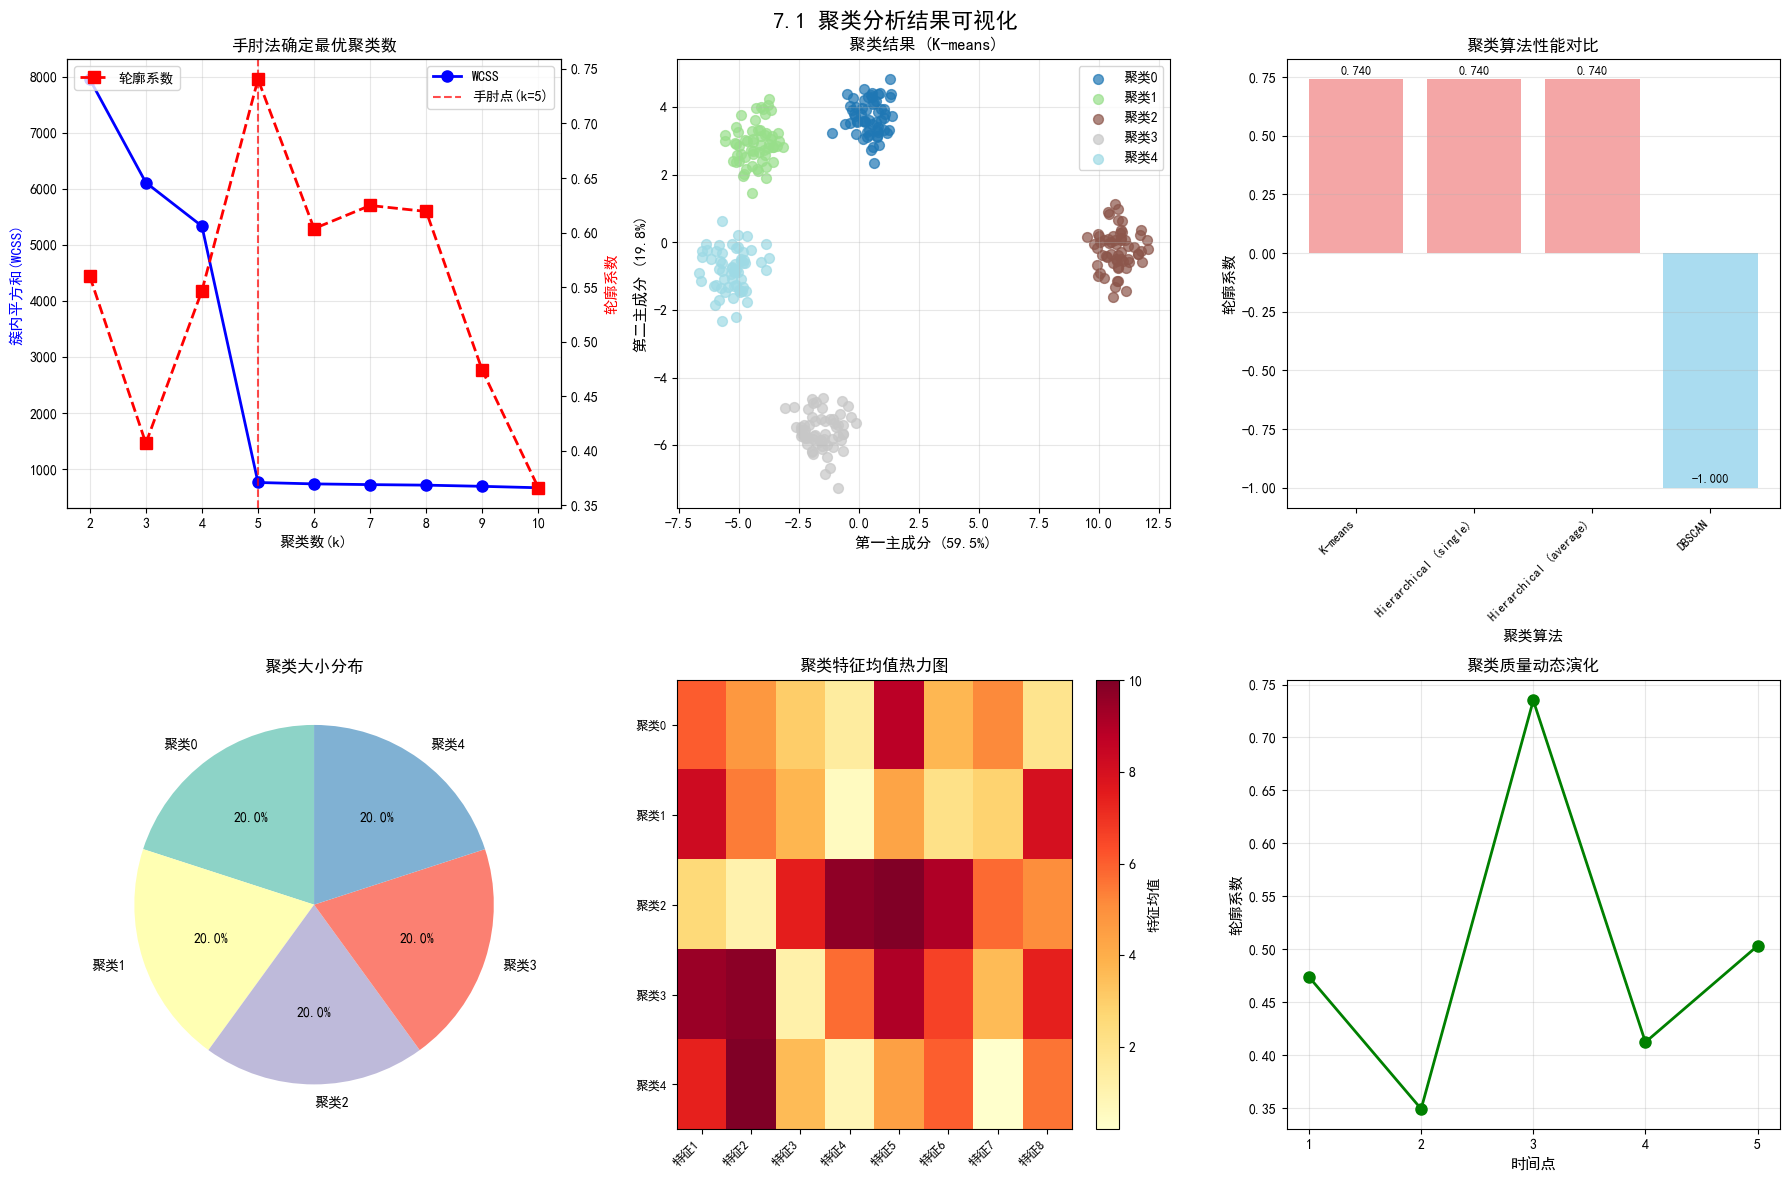

  - 生成判别分析可视化...


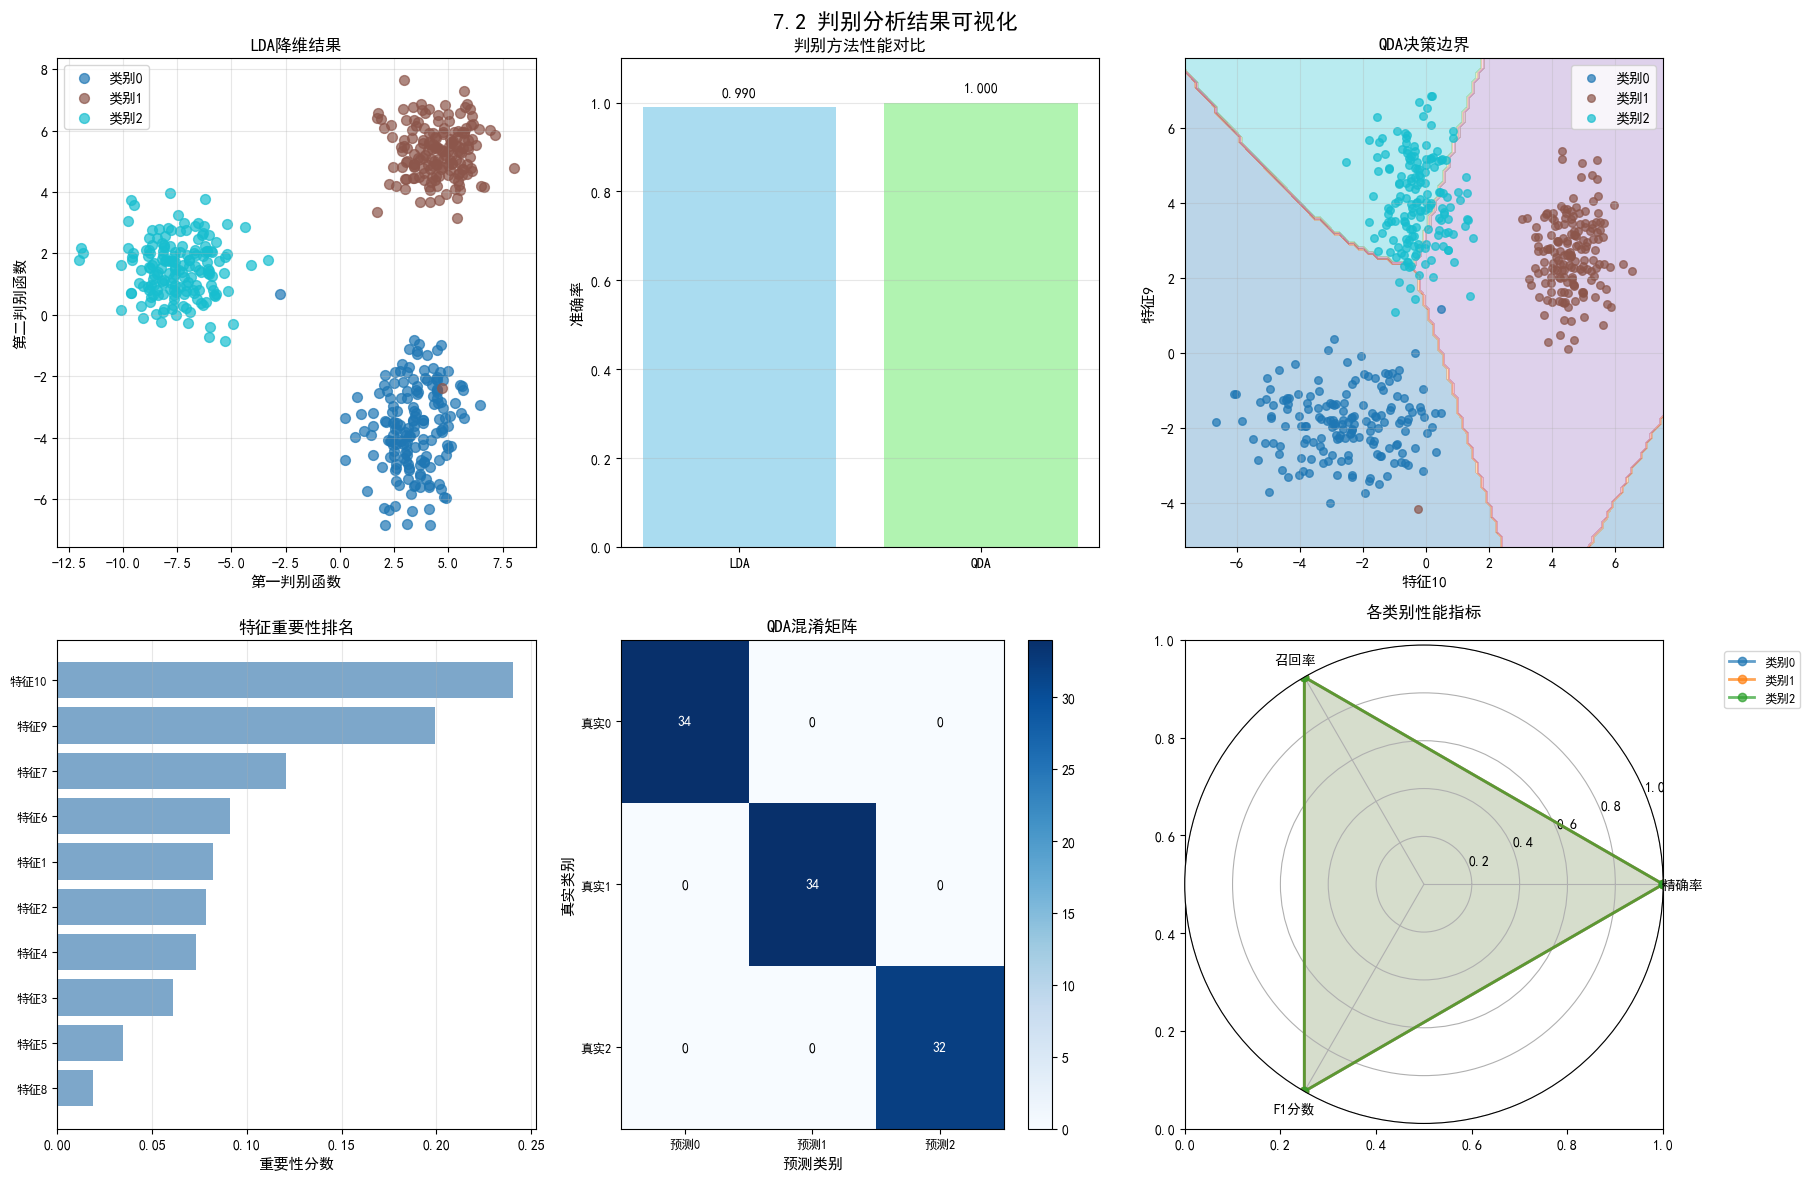


分析总结

聚类分析:
  • 最佳算法: K-means
  • 最优聚类数: 5
  • 轮廓系数: 0.7404

判别分析:
  • QDA准确率: 1.0000
  • QDA宏平均F1: 1.0000
  • QDA平均AUC: 1.0000

最重要的3个特征:
  • 特征10: 重要性=0.2403
  • 特征9: 重要性=0.1993
  • 特征7: 重要性=0.1205

第七章 聚类与分类分析 完成


In [2]:
import math
import random
import statistics
import copy
from typing import List, Dict, Any, Tuple, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================== 数据准备函数 ====================
def create_clustering_data(n_samples=300, n_features=8, n_clusters=5):
    """创建聚类分析用的模拟数据"""
    # 生成聚类中心
    cluster_centers = []
    for i in range(n_clusters):
        center = [random.uniform(0, 10) for _ in range(n_features)]
        cluster_centers.append(center)
    
    # 生成样本数据
    data = []
    labels_true = []
    cluster_sizes = [n_samples // n_clusters] * n_clusters
    for i in range(n_samples % n_clusters):
        cluster_sizes[i] += 1
    
    cluster_idx = 0
    for cluster_id in range(n_clusters):
        center = cluster_centers[cluster_id]
        for _ in range(cluster_sizes[cluster_id]):
            # 添加随机噪声
            point = [center[j] + random.uniform(-1, 1) for j in range(n_features)]
            data.append(point)
            labels_true.append(cluster_id)
    
    # 打乱数据
    combined = list(zip(data, labels_true))
    random.shuffle(combined)
    data[:], labels_true[:] = zip(*combined)
    
    return np.array(data), np.array(labels_true), np.array(cluster_centers)

def create_classification_data(n_samples=500, n_features=10, n_classes=3):
    """创建分类分析用的模拟数据"""
    data = []
    labels = []
    
    for class_id in range(n_classes):
        # 每个类别有不同的均值和方差
        mean = [random.uniform(-5, 5) for _ in range(n_features)]
        std = [random.uniform(0.5, 2.0) for _ in range(n_features)]
        
        for _ in range(n_samples // n_classes):
            point = [random.gauss(mean[j], std[j]) for j in range(n_features)]
            data.append(point)
            labels.append(class_id)
    
    # 为多出来的样本分配类别
    for i in range(n_samples % n_classes):
        class_id = i % n_classes
        mean = [random.uniform(-5, 5) for _ in range(n_features)]
        std = [random.uniform(0.5, 2.0) for _ in range(n_features)]
        point = [random.gauss(mean[j], std[j]) for j in range(n_features)]
        data.append(point)
        labels.append(class_id)
    
    # 打乱数据
    combined = list(zip(data, labels))
    random.shuffle(combined)
    data[:], labels[:] = zip(*combined)
    
    return np.array(data), np.array(labels)

# ==================== PCA实现（为了代码独立性）====================
class SimplePCA:
    """简化的PCA实现"""
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ratio_ = None
        
    def fit_transform(self, X):
        """拟合数据并转换"""
        # 中心化数据
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # 计算协方差矩阵
        cov_matrix = np.cov(X_centered.T)
        
        # 计算特征值和特征向量
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # 排序特征值（降序）
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 只保留前n_components个特征向量
        self.components_ = eigenvectors[:, :self.n_components].T
        
        # 计算解释方差比例
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / total_variance
        
        # 转换数据
        transformed = np.dot(X_centered, self.components_.T)
        
        return transformed

# ==================== 7.1 聚类分析 ====================
class ClusteringAnalysis:
    """聚类分析类"""
    
    def __init__(self, data, n_clusters_range=(2, 10)):
        self.data = data
        self.n_clusters_range = n_clusters_range
        self.results = {}
        
    def kmeans_clustering(self, n_clusters, max_iter=100):
        """K-means聚类算法"""
        n_samples, n_features = self.data.shape
        
        # 随机初始化聚类中心
        indices = random.sample(range(n_samples), n_clusters)
        centers = self.data[indices].copy()
        
        # 迭代优化
        for iteration in range(max_iter):
            # 分配样本到最近的聚类中心
            labels = []
            for point in self.data:
                distances = [np.linalg.norm(point - center) for center in centers]
                labels.append(np.argmin(distances))
            
            labels = np.array(labels)
            
            # 更新聚类中心
            new_centers = []
            for cluster_id in range(n_clusters):
                cluster_points = self.data[labels == cluster_id]
                if len(cluster_points) > 0:
                    new_center = np.mean(cluster_points, axis=0)
                else:
                    new_center = centers[cluster_id]
                new_centers.append(new_center)
            
            new_centers = np.array(new_centers)
            
            # 检查收敛
            if np.allclose(centers, new_centers, rtol=1e-4):
                break
            
            centers = new_centers
        
        # 计算轮廓系数
        silhouette_avg = self._calculate_silhouette_score(self.data, labels)
        
        # 计算WCSS（簇内平方和）
        wcss = 0
        for cluster_id in range(n_clusters):
            cluster_points = self.data[labels == cluster_id]
            if len(cluster_points) > 0:
                center = centers[cluster_id]
                wcss += np.sum(np.linalg.norm(cluster_points - center, axis=1) ** 2)
        
        return {
            'algorithm': 'K-means',
            'n_clusters': n_clusters,
            'labels': labels,
            'centers': centers,
            'silhouette_score': silhouette_avg,
            'wcss': wcss,
            'iterations': iteration + 1
        }
    
    def hierarchical_clustering(self, n_clusters, method='average'):
        """层次聚类算法"""
        n_samples = self.data.shape[0]
        
        # 初始化：每个样本作为一个簇
        clusters = [[i] for i in range(n_samples)]
        
        # 计算初始距离矩阵
        distance_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                distance_matrix[i, j] = np.linalg.norm(self.data[i] - self.data[j])
                distance_matrix[j, i] = distance_matrix[i, j]
        
        # 记录簇的距离
        cluster_distances = {}
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                cluster_distances[(i, j)] = distance_matrix[i, j]
        
        # 层次聚类
        while len(clusters) > n_clusters:
            # 找到距离最近的两个簇
            min_distance = float('inf')
            merge_pair = None
            
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    # 计算簇间距离
                    cluster_i = clusters[i]
                    cluster_j = clusters[j]
                    
                    if method == 'single':
                        # 单链接：最小距离
                        distance = min(distance_matrix[a, b] for a in cluster_i for b in cluster_j)
                    elif method == 'complete':
                        # 全链接：最大距离
                        distance = max(distance_matrix[a, b] for a in cluster_i for b in cluster_j)
                    else:  # average
                        # 平均链接：平均距离
                        total_distance = sum(distance_matrix[a, b] for a in cluster_i for b in cluster_j)
                        distance = total_distance / (len(cluster_i) * len(cluster_j))
                    
                    if distance < min_distance:
                        min_distance = distance
                        merge_pair = (i, j)
            
            if merge_pair:
                i, j = merge_pair
                # 合并簇
                clusters[i].extend(clusters[j])
                clusters.pop(j)
        
        # 创建标签
        labels = np.zeros(n_samples, dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_id
        
        # 计算轮廓系数
        silhouette_avg = self._calculate_silhouette_score(self.data, labels)
        
        return {
            'algorithm': f'Hierarchical ({method})',
            'n_clusters': n_clusters,
            'labels': labels,
            'silhouette_score': silhouette_avg,
            'method': method
        }
    
    def dbscan_clustering(self, eps=0.5, min_samples=5):
        """DBSCAN密度聚类算法"""
        n_samples = self.data.shape[0]
        
        # 标记：-1表示噪声点，0表示未访问，正整数表示簇ID
        labels = np.zeros(n_samples, dtype=int) - 2  # 初始化为-2表示未访问
        cluster_id = 0
        
        for i in range(n_samples):
            if labels[i] != -2:  # 已访问
                continue
            
            # 寻找邻域点
            neighbors = []
            for j in range(n_samples):
                if np.linalg.norm(self.data[i] - self.data[j]) <= eps:
                    neighbors.append(j)
            
            if len(neighbors) < min_samples:
                # 标记为噪声
                labels[i] = -1
                continue
            
            # 开始新的簇
            cluster_id += 1
            labels[i] = cluster_id
            
            # 扩展簇
            seed_set = set(neighbors)
            seed_set.discard(i)
            
            while seed_set:
                j = seed_set.pop()
                
                if labels[j] == -1:
                    # 将噪声点重新分配到簇中
                    labels[j] = cluster_id
                
                if labels[j] != -2:  # 已访问
                    continue
                
                labels[j] = cluster_id
                
                # 寻找j的邻域
                j_neighbors = []
                for k in range(n_samples):
                    if np.linalg.norm(self.data[j] - self.data[k]) <= eps:
                        j_neighbors.append(k)
                
                if len(j_neighbors) >= min_samples:
                    seed_set.update(j_neighbors)
        
        # 将未访问的点标记为噪声
        labels[labels == -2] = -1
        
        # 统计聚类数量（排除噪声点）
        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        n_clusters = len(unique_labels)
        
        # 计算轮廓系数（仅对非噪声点）
        non_noise_mask = labels != -1
        if np.sum(non_noise_mask) > 1:
            silhouette_avg = self._calculate_silhouette_score(
                self.data[non_noise_mask], 
                labels[non_noise_mask]
            )
        else:
            silhouette_avg = -1
        
        return {
            'algorithm': 'DBSCAN',
            'n_clusters': n_clusters,
            'labels': labels,
            'silhouette_score': silhouette_avg,
            'eps': eps,
            'min_samples': min_samples,
            'noise_points': np.sum(labels == -1)
        }
    
    def _calculate_silhouette_score(self, data, labels):
        """计算轮廓系数"""
        n_samples = len(data)
        
        if len(set(labels)) <= 1:
            return -1
        
        # 计算每个样本的轮廓系数
        silhouette_values = []
        
        for i in range(n_samples):
            # 计算a(i)：样本i到同簇其他样本的平均距离
            cluster_i = labels[i]
            same_cluster_indices = np.where(labels == cluster_i)[0]
            
            if len(same_cluster_indices) <= 1:
                a_i = 0
            else:
                distances = [np.linalg.norm(data[i] - data[j]) 
                           for j in same_cluster_indices if j != i]
                a_i = np.mean(distances) if distances else 0
            
            # 计算b(i)：样本i到其他簇的最小平均距离
            other_clusters = [c for c in set(labels) if c != cluster_i]
            b_i_values = []
            
            for cluster_j in other_clusters:
                other_cluster_indices = np.where(labels == cluster_j)[0]
                distances = [np.linalg.norm(data[i] - data[j]) 
                           for j in other_cluster_indices]
                b_i_values.append(np.mean(distances))
            
            b_i = min(b_i_values) if b_i_values else 0
            
            # 计算样本i的轮廓系数
            if max(a_i, b_i) > 0:
                s_i = (b_i - a_i) / max(a_i, b_i)
            else:
                s_i = 0
            
            silhouette_values.append(s_i)
        
        return np.mean(silhouette_values)
    
    def determine_optimal_clusters(self, max_clusters=10):
        """确定最优聚类数"""
        wcss_values = []
        silhouette_scores = []
        
        for k in range(2, max_clusters + 1):
            result = self.kmeans_clustering(k)
            wcss_values.append(result['wcss'])
            silhouette_scores.append(result['silhouette_score'])
        
        # 寻找手肘点（WCSS曲线的拐点）
        elbow_point = self._find_elbow_point(wcss_values)
        
        # 寻找最大轮廓系数
        best_silhouette = np.argmax(silhouette_scores) + 2  # +2因为从k=2开始
        
        return {
            'wcss_values': wcss_values,
            'silhouette_scores': silhouette_scores,
            'elbow_point': elbow_point,
            'best_silhouette': best_silhouette,
            'recommended_k': max(elbow_point, best_silhouette)
        }
    
    def _find_elbow_point(self, wcss_values):
        """寻找手肘点"""
        n_points = len(wcss_values)
        
        # 创建坐标点
        points = np.array([[i+2, wcss] for i, wcss in enumerate(wcss_values)])
        
        # 连接第一个和最后一个点
        first_point = points[0]
        last_point = points[-1]
        
        # 计算每个点到这条线的距离
        max_distance = 0
        elbow_idx = 0
        
        for i in range(1, n_points-1):
            point = points[i]
            distance = self._distance_to_line(point, first_point, last_point)
            
            if distance > max_distance:
                max_distance = distance
                elbow_idx = i
        
        return elbow_idx + 2  # +2因为从k=2开始
    
    def _distance_to_line(self, point, line_start, line_end):
        """计算点到直线的距离"""
        # 直线方向向量
        line_vec = line_end - line_start
        point_vec = point - line_start
        
        # 计算叉积的模
        cross_product = np.cross(line_vec, point_vec)
        line_length = np.linalg.norm(line_vec)
        
        if line_length == 0:
            return 0
        
        return abs(cross_product) / line_length
    
    def run_clustering_analysis(self, true_labels=None):
        """运行完整的聚类分析"""
        print("="*70)
        print("7.1 聚类分析")
        print("="*70)
        
        # 1. 确定最优聚类数
        print("\n1. 确定最优聚类数...")
        optimal_result = self.determine_optimal_clusters()
        
        recommended_k = optimal_result['recommended_k']
        print(f"  推荐聚类数: {recommended_k}")
        print(f"  手肘点方法: k={optimal_result['elbow_point']}")
        print(f"  轮廓系数方法: k={optimal_result['best_silhouette']}")
        
        # 2. 多算法聚类
        print("\n2. 多算法聚类实现与对比...")
        
        algorithms_results = []
        
        # K-means
        print("  - 运行K-means算法...")
        kmeans_result = self.kmeans_clustering(recommended_k)
        algorithms_results.append(kmeans_result)
        
        # 层次聚类（单链接）
        print("  - 运行层次聚类（单链接）...")
        hierarchical_single = self.hierarchical_clustering(recommended_k, method='single')
        algorithms_results.append(hierarchical_single)
        
        # 层次聚类（平均链接）
        print("  - 运行层次聚类（平均链接）...")
        hierarchical_average = self.hierarchical_clustering(recommended_k, method='average')
        algorithms_results.append(hierarchical_average)
        
        # DBSCAN
        print("  - 运行DBSCAN算法...")
        dbscan_result = self.dbscan_clustering(eps=1.0, min_samples=5)
        algorithms_results.append(dbscan_result)
        
        # 3. 算法对比
        print("\n3. 聚类算法性能对比:")
        print("  " + "-"*80)
        print(f"  {'算法':<25} {'聚类数':<10} {'轮廓系数':<12} {'其他指标':<30}")
        print("  " + "-"*80)
        
        for result in algorithms_results:
            algorithm_name = result['algorithm']
            n_clusters = result['n_clusters']
            silhouette = result['silhouette_score']
            
            extra_info = ""
            if algorithm_name == 'K-means':
                extra_info = f"WCSS: {result['wcss']:.2f}, 迭代次数: {result['iterations']}"
            elif 'Hierarchical' in algorithm_name:
                extra_info = f"链接方法: {result['method']}"
            elif algorithm_name == 'DBSCAN':
                extra_info = f"噪声点: {result['noise_points']}, eps: {result['eps']}"
            
            print(f"  {algorithm_name:<25} {n_clusters:<10} {silhouette:<12.4f} {extra_info:<30}")
        
        # 4. 聚类结果解释
        print("\n4. 聚类结果解释:")
        
        # 选择最佳算法
        best_result = max(algorithms_results, key=lambda x: x['silhouette_score'])
        print(f"  最佳算法: {best_result['algorithm']}")
        print(f"  轮廓系数: {best_result['silhouette_score']:.4f}")
        
        if true_labels is not None:
            # 计算调整兰德指数（如果真实标签可用）
            ari = self._calculate_adjusted_rand_index(best_result['labels'], true_labels)
            print(f"  调整兰德指数(ARI): {ari:.4f}")
        
        # 5. 动态演化分析（模拟）
        print("\n5. 动态演化分析:")
        
        # 模拟时间序列数据
        time_points = 5
        evolution_data = []
        
        for t in range(time_points):
            # 添加时间相关的扰动
            perturbed_data = self.data + np.random.normal(0, 0.1, self.data.shape)
            temp_clustering = ClusteringAnalysis(perturbed_data)
            result = temp_clustering.kmeans_clustering(recommended_k)
            evolution_data.append(result)
        
        print(f"  模拟了{time_points}个时间点的聚类演化")
        
        # 存储结果
        self.results = {
            'optimal_clusters': optimal_result,
            'algorithms': algorithms_results,
            'best_algorithm': best_result,
            'evolution': evolution_data
        }
        
        return self.results
    
    def _calculate_adjusted_rand_index(self, labels_pred, labels_true):
        """计算调整兰德指数"""
        n_samples = len(labels_true)
        
        # 创建混淆矩阵
        max_label = max(max(labels_pred), max(labels_true)) + 1
        contingency = np.zeros((max_label, max_label), dtype=int)
        
        for i in range(n_samples):
            contingency[labels_pred[i], labels_true[i]] += 1
        
        # 计算各个统计量
        sum_combinations = lambda x: x * (x-1) / 2 if x > 1 else 0
        
        a = sum(sum_combinations(n_ij) for n_ij in contingency.flatten())
        b = sum(sum_combinations(contingency[i, :].sum()) for i in range(max_label))
        c = sum(sum_combinations(contingency[:, j].sum()) for j in range(max_label))
        d = sum_combinations(n_samples)
        
        # 计算ARI
        if b + c - a == 0:
            return 1.0 if a == d else 0.0
        
        ari = (a - (b * c) / d) / ((b + c) / 2 - (b * c) / d)
        return ari
    
    def visualize_clustering_results(self, use_pca=True):
        """可视化聚类结果"""
        if not self.results:
            print("请先运行聚类分析")
            return
        
        best_result = self.results['best_algorithm']
        labels = best_result['labels']
        
        # 如果数据维度高，使用PCA降维
        if use_pca and self.data.shape[1] > 2:
            pca = SimplePCA(n_components=2)
            reduced_data = pca.fit_transform(self.data)
            explained_variance = pca.explained_variance_ratio_
        else:
            reduced_data = self.data[:, :2]  # 取前两个特征
            explained_variance = [1.0, 1.0]
        
        # 创建可视化图形
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('7.1 聚类分析结果可视化', fontsize=16, fontweight='bold')
        
        # 1. 最优聚类数确定图
        ax1 = axes[0, 0]
        optimal = self.results['optimal_clusters']
        
        x_range = range(2, len(optimal['wcss_values']) + 2)
        
        # WCSS曲线
        ax1.plot(x_range, optimal['wcss_values'], 'bo-', linewidth=2, markersize=8, label='WCSS')
        ax1.axvline(x=optimal['elbow_point'], color='r', linestyle='--', alpha=0.7, 
                   label=f'手肘点(k={optimal["elbow_point"]})')
        ax1.set_xlabel('聚类数(k)', fontsize=11)
        ax1.set_ylabel('簇内平方和(WCSS)', fontsize=11, color='b')
        ax1.set_title('手肘法确定最优聚类数', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # 添加第二个y轴用于轮廓系数
        ax1_twin = ax1.twinx()
        ax1_twin.plot(x_range, optimal['silhouette_scores'], 'rs--', linewidth=2, 
                     markersize=8, label='轮廓系数')
        ax1_twin.set_ylabel('轮廓系数', fontsize=11, color='r')
        ax1_twin.legend(loc='upper left')
        
        # 2. 聚类结果散点图
        ax2 = axes[0, 1]
        n_clusters = len(set(labels))
        
        # 为每个聚类分配颜色
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
        
        for cluster_id in range(n_clusters):
            cluster_points = reduced_data[labels == cluster_id]
            if len(cluster_points) > 0:
                ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                          color=colors[cluster_id], s=50, alpha=0.7, 
                          label=f'聚类{cluster_id}')
        
        if use_pca:
            ax2.set_xlabel(f'第一主成分 ({explained_variance[0]*100:.1f}%)', fontsize=11)
            ax2.set_ylabel(f'第二主成分 ({explained_variance[1]*100:.1f}%)', fontsize=11)
        else:
            ax2.set_xlabel('特征1', fontsize=11)
            ax2.set_ylabel('特征2', fontsize=11)
        
        ax2.set_title(f'聚类结果 ({best_result["algorithm"]})', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 算法对比条形图
        ax3 = axes[0, 2]
        algorithms = self.results['algorithms']
        
        algorithm_names = [result['algorithm'] for result in algorithms]
        silhouette_scores = [result['silhouette_score'] for result in algorithms]
        
        colors_bar = ['skyblue' if score != max(silhouette_scores) else 'lightcoral' 
                     for score in silhouette_scores]
        
        bars = ax3.bar(range(len(algorithms)), silhouette_scores, color=colors_bar, alpha=0.7)
        ax3.set_xlabel('聚类算法', fontsize=11)
        ax3.set_ylabel('轮廓系数', fontsize=11)
        ax3.set_title('聚类算法性能对比', fontsize=12, fontweight='bold')
        ax3.set_xticks(range(len(algorithms)))
        ax3.set_xticklabels(algorithm_names, rotation=45, ha='right', fontsize=9)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 在条形上添加数值
        for i, (bar, score) in enumerate(zip(bars, silhouette_scores)):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 4. 聚类大小分布饼图
        ax4 = axes[1, 0]
        cluster_sizes = []
        for cluster_id in range(n_clusters):
            size = np.sum(labels == cluster_id)
            cluster_sizes.append(size)
        
        # 过滤掉大小为0的聚类
        non_zero_indices = [i for i, size in enumerate(cluster_sizes) if size > 0]
        non_zero_sizes = [cluster_sizes[i] for i in non_zero_indices]
        non_zero_labels = [f'聚类{i}' for i in non_zero_indices]
        
        if non_zero_sizes:
            wedges, texts, autotexts = ax4.pie(non_zero_sizes, labels=non_zero_labels,
                                              autopct='%1.1f%%', startangle=90,
                                              colors=plt.cm.Set3(range(len(non_zero_sizes))))
            
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontweight('bold')
            
            ax4.set_title('聚类大小分布', fontsize=12, fontweight='bold')
        
        # 5. 特征重要性热力图
        ax5 = axes[1, 1]
        n_features = min(8, self.data.shape[1])
        
        # 计算每个聚类中每个特征的均值
        feature_importance = np.zeros((n_clusters, n_features))
        
        for cluster_id in range(n_clusters):
            cluster_data = self.data[labels == cluster_id]
            if len(cluster_data) > 0:
                feature_importance[cluster_id] = np.mean(cluster_data[:, :n_features], axis=0)
        
        im = ax5.imshow(feature_importance, cmap='YlOrRd', aspect='auto')
        
        ax5.set_xticks(range(n_features))
        ax5.set_xticklabels([f'特征{i+1}' for i in range(n_features)], 
                           rotation=45, ha='right', fontsize=9)
        ax5.set_yticks(range(n_clusters))
        ax5.set_yticklabels([f'聚类{i}' for i in range(n_clusters)], fontsize=9)
        
        ax5.set_title('聚类特征均值热力图', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax5, label='特征均值')
        
        # 6. 动态演化分析图
        ax6 = axes[1, 2]
        
        if 'evolution' in self.results:
            evolution_data = self.results['evolution']
            time_points = len(evolution_data)
            
            # 提取每个时间点的轮廓系数
            silhouette_over_time = [result['silhouette_score'] for result in evolution_data]
            
            ax6.plot(range(1, time_points + 1), silhouette_over_time, 'go-', 
                    linewidth=2, markersize=8)
            ax6.set_xlabel('时间点', fontsize=11)
            ax6.set_ylabel('轮廓系数', fontsize=11)
            ax6.set_title('聚类质量动态演化', fontsize=12, fontweight='bold')
            ax6.grid(True, alpha=0.3)
            ax6.set_xticks(range(1, time_points + 1))
        
        plt.tight_layout()
        plt.show()

# ==================== 7.2 判别分析 ====================
class DiscriminantAnalysis:
    """判别分析类"""
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.n_samples, self.n_features = data.shape
        self.classes = np.unique(labels)
        self.n_classes = len(self.classes)
        self.results = {}
    
    def linear_discriminant_analysis(self):
        """线性判别分析(LDA)"""
        # 计算总体均值
        overall_mean = np.mean(self.data, axis=0)
        
        # 计算类内散度矩阵(S_w)和类间散度矩阵(S_b)
        S_w = np.zeros((self.n_features, self.n_features))
        S_b = np.zeros((self.n_features, self.n_features))
        
        for class_id in self.classes:
            # 获取当前类别的样本
            class_data = self.data[self.labels == class_id]
            n_class = len(class_data)
            
            if n_class > 0:
                # 计算类别均值
                class_mean = np.mean(class_data, axis=0)
                
                # 计算类内散度
                class_scatter = np.zeros((self.n_features, self.n_features))
                for sample in class_data:
                    diff = (sample - class_mean).reshape(-1, 1)
                    class_scatter += np.dot(diff, diff.T)
                
                S_w += class_scatter
                
                # 计算类间散度贡献
                mean_diff = (class_mean - overall_mean).reshape(-1, 1)
                S_b += n_class * np.dot(mean_diff, mean_diff.T)
        
        # 解决广义特征值问题：S_b * w = λ * S_w * w
        # 简化：使用伪逆
        try:
            S_w_inv = np.linalg.pinv(S_w)
            matrix = np.dot(S_w_inv, S_b)
            
            # 计算特征值和特征向量
            eigenvalues, eigenvectors = np.linalg.eig(matrix)
            
            # 排序特征值（降序）
            idx = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            
            # 只保留实数部分
            eigenvalues = np.real(eigenvalues)
            eigenvectors = np.real(eigenvectors)
            
            # 选择前(min(n_classes-1, n_features))个判别向量
            n_components = min(self.n_classes - 1, self.n_features)
            selected_eigenvectors = eigenvectors[:, :n_components]
            
            # 投影数据
            transformed_data = np.dot(self.data, selected_eigenvectors)
            
            # 计算判别函数系数
            coefficients = selected_eigenvectors.T
            
            return {
                'method': 'LDA',
                'eigenvalues': eigenvalues[:n_components],
                'eigenvectors': selected_eigenvectors,
                'coefficients': coefficients,
                'transformed_data': transformed_data,
                'explained_variance_ratio': eigenvalues[:n_components] / np.sum(eigenvalues[:n_components]),
                'n_components': n_components
            }
            
        except np.linalg.LinAlgError:
            print("警告：LDA计算失败，使用简化版本")
            return None
    
    def quadratic_discriminant_analysis(self):
        """二次判别分析(QDA)"""
        results = {}
        
        for class_id in self.classes:
            class_data = self.data[self.labels == class_id]
            n_class = len(class_data)
            
            if n_class > 0:
                # 计算类别均值
                class_mean = np.mean(class_data, axis=0)
                
                # 计算类别协方差矩阵
                if n_class > 1:
                    class_cov = np.cov(class_data, rowvar=False)
                    # 添加正则化项避免奇异性
                    class_cov += np.eye(self.n_features) * 1e-6
                else:
                    class_cov = np.eye(self.n_features)
                
                # 计算类别先验概率
                prior_prob = n_class / self.n_samples
                
                results[class_id] = {
                    'mean': class_mean,
                    'covariance': class_cov,
                    'prior': prior_prob,
                    'cov_inv': np.linalg.pinv(class_cov),
                    'cov_det': np.linalg.det(class_cov)
                }
        
        return {
            'method': 'QDA',
            'class_parameters': results,
            'n_classes': self.n_classes
        }
    
    def predict_qda(self, qda_result, X_test):
        """使用QDA模型预测"""
        predictions = []
        probabilities = []
        
        for sample in X_test:
            class_scores = []
            
            for class_id, params in qda_result['class_parameters'].items():
                # 计算二次判别函数
                diff = sample - params['mean']
                quad_term = -0.5 * np.dot(np.dot(diff.T, params['cov_inv']), diff)
                det_term = -0.5 * np.log(params['cov_det'])
                prior_term = np.log(params['prior'])
                
                score = quad_term + det_term + prior_term
                class_scores.append((class_id, score))
            
            # 选择最高得分的类别
            best_class, best_score = max(class_scores, key=lambda x: x[1])
            predictions.append(best_class)
            
            # 计算概率（softmax）
            scores = [score for _, score in class_scores]
            exp_scores = np.exp(scores - np.max(scores))  # 数值稳定性
            probs = exp_scores / np.sum(exp_scores)
            probabilities.append(probs)
        
        return np.array(predictions), np.array(probabilities)
    
    def evaluate_classification(self, y_true, y_pred, y_prob=None):
        """评估分类效果"""
        # 计算准确率
        accuracy = np.mean(y_true == y_pred)
        
        # 计算混淆矩阵
        confusion_matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        
        for true, pred in zip(y_true, y_pred):
            confusion_matrix[true, pred] += 1
        
        # 计算各类别的精确率、召回率、F1分数
        precision_scores = []
        recall_scores = []
        f1_scores = []
        
        for class_id in range(self.n_classes):
            tp = confusion_matrix[class_id, class_id]
            fp = np.sum(confusion_matrix[:, class_id]) - tp
            fn = np.sum(confusion_matrix[class_id, :]) - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # 计算宏平均
        macro_precision = np.mean(precision_scores)
        macro_recall = np.mean(recall_scores)
        macro_f1 = np.mean(f1_scores)
        
        # 计算加权平均
        class_counts = np.bincount(y_true)
        weights = class_counts / len(y_true)
        
        weighted_precision = np.sum(np.array(precision_scores) * weights)
        weighted_recall = np.sum(np.array(recall_scores) * weights)
        weighted_f1 = np.sum(np.array(f1_scores) * weights)
        
        # 计算AUC-ROC（如果提供概率）
        if y_prob is not None:
            auc_scores = []
            for class_id in range(self.n_classes):
                y_true_binary = (y_true == class_id).astype(int)
                y_prob_class = y_prob[:, class_id]
                
                # 计算AUC（简化版）
                auc = self._calculate_auc(y_true_binary, y_prob_class)
                auc_scores.append(auc)
            
            mean_auc = np.mean(auc_scores)
        else:
            auc_scores = None
            mean_auc = None
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': confusion_matrix,
            'precision': precision_scores,
            'recall': recall_scores,
            'f1': f1_scores,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'weighted_precision': weighted_precision,
            'weighted_recall': weighted_recall,
            'weighted_f1': weighted_f1,
            'auc_scores': auc_scores,
            'mean_auc': mean_auc
        }
    
    def _calculate_auc(self, y_true, y_score):
        """计算AUC（简化版）"""
        # 获取正负样本
        positive_indices = np.where(y_true == 1)[0]
        negative_indices = np.where(y_true == 0)[0]
        
        if len(positive_indices) == 0 or len(negative_indices) == 0:
            return 0.5  # 无法计算，返回随机值
        
        # 计算所有正负样本对的比较
        correct_pairs = 0
        total_pairs = len(positive_indices) * len(negative_indices)
        
        for pos_idx in positive_indices:
            for neg_idx in negative_indices:
                if y_score[pos_idx] > y_score[neg_idx]:
                    correct_pairs += 1
                elif y_score[pos_idx] == y_score[neg_idx]:
                    correct_pairs += 0.5
        
        return correct_pairs / total_pairs
    
    def feature_importance_analysis(self):
        """特征重要性分析"""
        # 使用LDA的判别向量权重作为特征重要性
        lda_result = self.linear_discriminant_analysis()
        
        if lda_result is not None:
            # 计算每个特征的判别能力
            feature_importance = np.sum(np.abs(lda_result['coefficients']), axis=0)
            feature_importance = feature_importance / np.sum(feature_importance)
        else:
            # 使用方差作为替代
            feature_variance = np.var(self.data, axis=0)
            feature_importance = feature_variance / np.sum(feature_variance)
        
        # 计算类别可分性度量
        class_separability = []
        for i in range(self.n_features):
            # 计算费希尔判别比
            overall_mean = np.mean(self.data[:, i])
            
            between_var = 0
            within_var = 0
            
            for class_id in self.classes:
                class_data = self.data[self.labels == class_id, i]
                n_class = len(class_data)
                
                if n_class > 0:
                    class_mean = np.mean(class_data)
                    between_var += n_class * (class_mean - overall_mean) ** 2
                    
                    if n_class > 1:
                        class_var = np.var(class_data)
                        within_var += (n_class - 1) * class_var
            
            if within_var > 0:
                fisher_ratio = between_var / within_var
            else:
                fisher_ratio = 0
            
            class_separability.append(fisher_ratio)
        
        return {
            'feature_importance': feature_importance,
            'class_separability': class_separability,
            'sorted_features': np.argsort(feature_importance)[::-1]
        }
    
    def run_discriminant_analysis(self, test_split=0.2):
        """运行完整的判别分析"""
        print("\n" + "="*70)
        print("7.2 判别分析")
        print("="*70)
        
        # 1. 划分训练集和测试集
        print("\n1. 数据准备...")
        n_test = int(self.n_samples * test_split)
        indices = list(range(self.n_samples))
        random.shuffle(indices)
        
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]
        
        X_train = self.data[train_indices]
        y_train = self.labels[train_indices]
        X_test = self.data[test_indices]
        y_test = self.labels[test_indices]
        
        print(f"  训练集大小: {len(X_train)} 样本")
        print(f"  测试集大小: {len(X_test)} 样本")
        print(f"  类别数量: {self.n_classes}")
        
        # 2. LDA分析
        print("\n2. 线性判别分析(LDA)...")
        lda_result = self.linear_discriminant_analysis()
        
        if lda_result:
            print(f"  提取了 {lda_result['n_components']} 个判别函数")
            print(f"  解释方差比例: {lda_result['explained_variance_ratio']}")
            
            # 使用LDA进行降维和分类
            lda_coefficients = lda_result['coefficients']
            
            # 训练LDA分类器（简化）
            X_train_lda = np.dot(X_train, lda_coefficients.T)
            X_test_lda = np.dot(X_test, lda_coefficients.T)
            
            # 使用最近质心分类
            centroids = []
            for class_id in self.classes:
                class_data = X_train_lda[y_train == class_id]
                if len(class_data) > 0:
                    centroid = np.mean(class_data, axis=0)
                    centroids.append((class_id, centroid))
            
            # 预测
            y_pred_lda = []
            for sample in X_test_lda:
                distances = [np.linalg.norm(sample - centroid) for _, centroid in centroids]
                closest_class = centroids[np.argmin(distances)][0]
                y_pred_lda.append(closest_class)
            
            y_pred_lda = np.array(y_pred_lda)
            
            # 评估
            lda_evaluation = self.evaluate_classification(y_test, y_pred_lda)
            print(f"  LDA准确率: {lda_evaluation['accuracy']:.4f}")
        else:
            lda_result = None
            lda_evaluation = None
            print("  LDA分析失败")
        
        # 3. QDA分析
        print("\n3. 二次判别分析(QDA)...")
        qda_result = self.quadratic_discriminant_analysis()
        
        y_pred_qda, y_prob_qda = self.predict_qda(qda_result, X_test)
        qda_evaluation = self.evaluate_classification(y_test, y_pred_qda, y_prob_qda)
        
        print(f"  QDA准确率: {qda_evaluation['accuracy']:.4f}")
        print(f"  QDA宏平均F1: {qda_evaluation['macro_f1']:.4f}")
        
        if qda_evaluation['mean_auc']:
            print(f"  QDA平均AUC: {qda_evaluation['mean_auc']:.4f}")
        
        # 4. 特征重要性分析
        print("\n4. 特征重要性分析...")
        feature_analysis = self.feature_importance_analysis()
        
        print("  最重要的5个特征:")
        top_features = feature_analysis['sorted_features'][:5]
        for i, feat_idx in enumerate(top_features):
            importance = feature_analysis['feature_importance'][feat_idx]
            separability = feature_analysis['class_separability'][feat_idx]
            print(f"    特征{feat_idx+1}: 重要性={importance:.4f}, 可分性={separability:.4f}")
        
        # 存储结果
        self.results = {
            'lda': lda_result,
            'qda': qda_result,
            'lda_evaluation': lda_evaluation,
            'qda_evaluation': qda_evaluation,
            'feature_analysis': feature_analysis,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred_lda': y_pred_lda if lda_result else None,
            'y_pred_qda': y_pred_qda,
            'y_prob_qda': y_prob_qda
        }
        
        return self.results
    
    def visualize_discriminant_results(self):
        """可视化判别分析结果"""
        if not self.results:
            print("请先运行判别分析")
            return
        
        # 创建可视化图形
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('7.2 判别分析结果可视化', fontsize=16, fontweight='bold')
        
        # 1. LDA降维结果
        ax1 = axes[0, 0]
        
        if self.results['lda']:
            lda_result = self.results['lda']
            X_lda = lda_result['transformed_data'][:, :2]  # 取前两个判别方向
            
            # 绘制训练集
            colors = plt.cm.tab10(np.linspace(0, 1, self.n_classes))
            
            for class_id in self.classes:
                class_indices = np.where(self.labels == class_id)[0]
                if len(class_indices) > 0:
                    class_points = X_lda[class_indices]
                    ax1.scatter(class_points[:, 0], class_points[:, 1], 
                              color=colors[class_id], s=50, alpha=0.7, 
                              label=f'类别{class_id}')
            
            ax1.set_xlabel('第一判别函数', fontsize=11)
            ax1.set_ylabel('第二判别函数', fontsize=11)
            ax1.set_title('LDA降维结果', fontsize=12, fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        else:
            ax1.text(0.5, 0.5, 'LDA分析不可用', ha='center', va='center', fontsize=12)
            ax1.set_title('LDA降维结果', fontsize=12, fontweight='bold')
        
        # 2. 方法对比条形图
        ax2 = axes[0, 1]
        
        methods = ['LDA', 'QDA']
        accuracies = []
        
        if self.results['lda_evaluation']:
            accuracies.append(self.results['lda_evaluation']['accuracy'])
        else:
            accuracies.append(0)
        
        accuracies.append(self.results['qda_evaluation']['accuracy'])
        
        colors_bar = ['skyblue', 'lightgreen']
        bars = ax2.bar(methods, accuracies, color=colors_bar, alpha=0.7)
        
        ax2.set_ylabel('准确率', fontsize=11)
        ax2.set_title('判别方法性能对比', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 在条形上添加数值
        for i, (bar, acc) in enumerate(zip(bars, accuracies)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
        
        # 3. QDA分类边界（2D示例）
        ax3 = axes[0, 2]
        
        # 选择两个最重要的特征
        feature_analysis = self.results['feature_analysis']
        top_features = feature_analysis['sorted_features'][:2]
        
        if len(top_features) >= 2:
            X_2d = self.data[:, top_features]
            
            # 创建网格
            x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
            y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                                np.linspace(y_min, y_max, 100))
            
            # 在网格点上进行QDA预测
            grid_points = np.c_[xx.ravel(), yy.ravel()]
            
            # 扩展特征到原始维度
            full_grid = np.zeros((grid_points.shape[0], self.n_features))
            full_grid[:, top_features[0]] = grid_points[:, 0]
            full_grid[:, top_features[1]] = grid_points[:, 1]
            
            # 使用训练好的QDA模型预测
            qda_result = self.results['qda']
            grid_pred, _ = self.predict_qda(qda_result, full_grid)
            grid_pred = grid_pred.reshape(xx.shape)
            
            # 绘制决策边界
            ax3.contourf(xx, yy, grid_pred, alpha=0.3, cmap=plt.cm.tab10)
            
            # 绘制数据点
            for class_id in self.classes:
                class_indices = np.where(self.labels == class_id)[0]
                if len(class_indices) > 0:
                    class_points = X_2d[class_indices]
                    ax3.scatter(class_points[:, 0], class_points[:, 1], 
                              color=colors[class_id], s=30, alpha=0.7,
                              label=f'类别{class_id}')
            
            ax3.set_xlabel(f'特征{top_features[0]+1}', fontsize=11)
            ax3.set_ylabel(f'特征{top_features[1]+1}', fontsize=11)
            ax3.set_title('QDA决策边界', fontsize=12, fontweight='bold')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 4. 特征重要性条形图
        ax4 = axes[1, 0]
        
        n_features_to_show = min(10, self.n_features)
        feature_importance = self.results['feature_analysis']['feature_importance']
        
        # 排序特征
        sorted_indices = np.argsort(feature_importance)[-n_features_to_show:][::-1]
        sorted_importance = feature_importance[sorted_indices]
        feature_labels = [f'特征{i+1}' for i in sorted_indices]
        
        bars = ax4.barh(range(n_features_to_show), sorted_importance, alpha=0.7, color='steelblue')
        ax4.set_yticks(range(n_features_to_show))
        ax4.set_yticklabels(feature_labels, fontsize=9)
        ax4.set_xlabel('重要性分数', fontsize=11)
        ax4.set_title('特征重要性排名', fontsize=12, fontweight='bold')
        ax4.invert_yaxis()  # 最重要的在顶部
        ax4.grid(True, alpha=0.3, axis='x')
        
        # 5. 混淆矩阵热力图
        ax5 = axes[1, 1]
        
        cm = self.results['qda_evaluation']['confusion_matrix']
        im = ax5.imshow(cm, cmap='Blues', aspect='auto')
        
        ax5.set_xticks(range(self.n_classes))
        ax5.set_yticks(range(self.n_classes))
        ax5.set_xticklabels([f'预测{i}' for i in range(self.n_classes)], fontsize=9)
        ax5.set_yticklabels([f'真实{i}' for i in range(self.n_classes)], fontsize=9)
        ax5.set_xlabel('预测类别', fontsize=11)
        ax5.set_ylabel('真实类别', fontsize=11)
        ax5.set_title('QDA混淆矩阵', fontsize=12, fontweight='bold')
        
        # 在单元格中添加数值
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                ax5.text(j, i, str(cm[i, j]), ha='center', va='center', 
                        color='white' if cm[i, j] > cm.max()/2 else 'black',
                        fontsize=10, fontweight='bold')
        
        plt.colorbar(im, ax=ax5)
        
        # 6. 类别性能指标雷达图
        ax6 = axes[1, 2]
        
        qda_eval = self.results['qda_evaluation']
        
        # 创建雷达图
        categories = ['精确率', '召回率', 'F1分数']
        
        if len(categories) >= 2:
            angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
            angles += angles[:1]
            
            ax6 = plt.subplot(236, polar=True)
            
            # 绘制每个类别的性能
            for class_id in range(self.n_classes):
                values = [
                    qda_eval['precision'][class_id],
                    qda_eval['recall'][class_id],
                    qda_eval['f1'][class_id]
                ]
                values += values[:1]
                
                ax6.plot(angles, values, 'o-', linewidth=2, 
                        label=f'类别{class_id}', alpha=0.7)
                ax6.fill(angles, values, alpha=0.1)
            
            ax6.set_xticks(angles[:-1])
            ax6.set_xticklabels(categories, fontsize=10)
            ax6.set_ylim(0, 1.0)
            ax6.set_title('各类别性能指标', fontsize=12, fontweight='bold', pad=20)
            ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        
        plt.tight_layout()
        plt.show()

# ==================== 主程序 ====================
def main():
    """主函数"""
    print("="*70)
    print("第七章 聚类与分类分析")
    print("="*70)
    
    # 1. 创建数据
    print("\n1. 创建模拟数据...")
    
    # 创建聚类数据
    clustering_data, true_labels, _ = create_clustering_data(
        n_samples=300, 
        n_features=8, 
        n_clusters=5
    )
    
    # 创建分类数据
    classification_data, classification_labels = create_classification_data(
        n_samples=500,
        n_features=10,
        n_classes=3
    )
    
    print(f"  聚类数据: {clustering_data.shape[0]} 样本, {clustering_data.shape[1]} 特征")
    print(f"  分类数据: {classification_data.shape[0]} 样本, {classification_data.shape[1]} 特征")
    
    # 2. 聚类分析
    print("\n2. 进行聚类分析...")
    clustering_analysis = ClusteringAnalysis(clustering_data)
    clustering_results = clustering_analysis.run_clustering_analysis(true_labels)
    
    # 3. 判别分析
    print("\n3. 进行判别分析...")
    discriminant_analysis = DiscriminantAnalysis(classification_data, classification_labels)
    discriminant_results = discriminant_analysis.run_discriminant_analysis()
    
    # 4. 生成可视化
    print("\n4. 生成可视化图表...")
    
    # 聚类分析可视化
    print("  - 生成聚类分析可视化...")
    clustering_analysis.visualize_clustering_results()
    
    # 判别分析可视化
    print("  - 生成判别分析可视化...")
    discriminant_analysis.visualize_discriminant_results()
    
    # 5. 总结
    print("\n" + "="*70)
    print("分析总结")
    print("="*70)
    
    # 聚类分析总结
    best_clustering = clustering_results['best_algorithm']
    print(f"\n聚类分析:")
    print(f"  • 最佳算法: {best_clustering['algorithm']}")
    print(f"  • 最优聚类数: {best_clustering['n_clusters']}")
    print(f"  • 轮廓系数: {best_clustering['silhouette_score']:.4f}")
    
    # 判别分析总结
    qda_eval = discriminant_results['qda_evaluation']
    print(f"\n判别分析:")
    print(f"  • QDA准确率: {qda_eval['accuracy']:.4f}")
    print(f"  • QDA宏平均F1: {qda_eval['macro_f1']:.4f}")
    if qda_eval['mean_auc']:
        print(f"  • QDA平均AUC: {qda_eval['mean_auc']:.4f}")
    
    # 特征重要性总结
    feature_analysis = discriminant_results['feature_analysis']
    top_features = feature_analysis['sorted_features'][:3]
    print(f"\n最重要的3个特征:")
    for i, feat_idx in enumerate(top_features):
        importance = feature_analysis['feature_importance'][feat_idx]
        print(f"  • 特征{feat_idx+1}: 重要性={importance:.4f}")
    
    print("\n" + "="*70)
    print("第七章 聚类与分类分析 完成")
    print("="*70)

if __name__ == "__main__":
    main()